In [ ]:
import os
import paddle
from paddle import nn ,optimizer
from paddle.vision import datasets
import paddle.vision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#加载数据集

In [ ]:
transform = Compose([Normalize(mean=[127.5],
                               std=[127.5],
                               data_format='CHW')])

train_dataset=paddle.vision.datasets.MNIST(mode="train", transform=transform)
eval_dataset=paddle.vision.datasets.MNIST(mode="test", transform=transform)

#加载训练数据
train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

#加载测试数据集
test_loader = paddle.io.DataLoader(
    eval_dataset,
    batch_size=1000,
    shuffle=True
)

#搭建LeNet网络
![](https://ai-studio-static-online.cdn.bcebos.com/3af630e7969d4751b4f24300f7cd88874340412d9ad84cc585c6865c07ca917b)

In [ ]:
#构建模型，input_size = 1*28*28
class LeNet(nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2D(1,6,5,1,2), #6*28*28
            nn.ReLU(),
            nn.MaxPool2D(2,2), #6*14*14
        )

        self.conv2 = nn.Sequential(
            nn.Conv2D(6,16,5), #16*10*10
            nn.ReLU(),
            nn.MaxPool2D(2,2), #16*5*5
        )

        self.fc = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.fc(x)
        return x

In [ ]:
model = LeNet()
model

LeNet(
  (conv1): Sequential(
    (0): Conv2D(1, 6, kernel_size=[5, 5], padding=2, data_format=NCHW)
    (1): ReLU()
    (2): MaxPool2D(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2D(6, 16, kernel_size=[5, 5], data_format=NCHW)
    (1): ReLU()
    (2): MaxPool2D(kernel_size=2, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, dtype=float32)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, dtype=float32)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, dtype=float32)
  )
)

#训练模型

In [219]:
use_gpu = False
place = paddle.CUDAPlace(0) if use_gpu else paddle.CPUPlace()

losses = []

with paddle.fluid.dygraph.guard(place):
    #训练
    model = LeNet()
    model.train()

    # optim = optimizer.Adam(learning_rate=0.001, parameters=model.parameters()) #优化算法
    optim = fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=model.parameters())
    criterion = nn.CrossEntropyLoss() #损失函数

    epochs = 10
    for epoch in range(epochs):
        for batch_id,(data, target) in enumerate(train_loader):
            data = paddle.fluid.dygraph.to_variable(data)
            target = paddle.fluid.dygraph.to_variable(target)

            #前向计算的过程
            predict = model(data)
            
            #计算损失，取一个批次样本损失的平均值
            loss = criterion(predict, target)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                losses.append(np.squeeze(avg_loss.numpy()))
                print("epoch: {}, batch: {}, loss is: {}".format(epoch+1, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optim.minimize(avg_loss)
            model.clear_gradients()

    #保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

epoch: 1, batch: 0, loss is: [3.116168]
epoch: 1, batch: 200, loss is: [0.1096438]
epoch: 1, batch: 400, loss is: [0.23729137]
epoch: 1, batch: 600, loss is: [0.07169929]


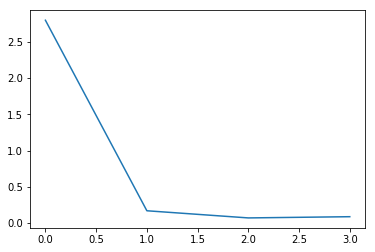

In [221]:
plt.plot(range(len(losses)), losses)

#测试模型

In [ ]:
with paddle.fluid.dygraph.guard(place):
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        data = paddle.fluid.dygraph.to_variable(data)
        target = paddle.fluid.dygraph.to_variable(target)
        output = model(data)
        test_loss += criterion(output, target).cpu().item()
        correct += (np.argmax(output,axis=1) == target.numpy().reshape(-1)).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.6f}, Accuracy:{}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100*correct/len(test_loader.dataset)))


Test set: Average loss: 0.000062, Accuracy:9862/10000 (99%)

